$\newcommand{jX}{\mathcal{X}}$
$\newcommand{jE}{\mathcal{E}}$

**Algorithm.** Let $\jX$ be a polygon. Let's consider the following minimization of $\jX$ given an error set $\jE$:

For all constraints:

1. Drop the constraint, creating a new vertex.
2. Check whether the new vertex lies in $\jX\oplus \jE$.
3. If not, put the constraint back.

The result is guaranteed to be within $\jX\oplus \jE$ and has less or equal number the vertices than $\jE$.

**Objectives.** In this worksheet the goal is to have a look at the behaviour of this algorithm in some "random" instances. We want to get some intuition with respect to:

1. What is the average reduction that is obtained?
2. How is the error depending in the order of how we draw the constraints?
3. How does the error radius influence the minimal edge length for edge removal to take place? 
4. How does it behave with errors that have a rectangular shape? 

For these experiments we make use of the [polyhedron_tools](https://github.com/mforets/polyhedron_tools) module. 

## Random polygons, vertex and edge manipulations

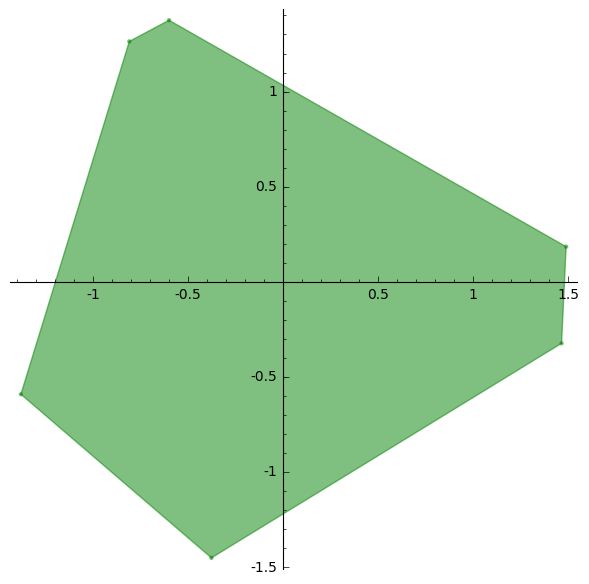

In [3]:
from polyhedron_tools.polygons import random_polygon_2d

# pick the number of vertices
nvertices = 6

# scaling factor
scale = 1.5

# generate a random polygon
P = random_polygon_2d(nvertices, scale=scale)

P.plot(alpha=0.5, color='green')

Let's check if the vertices are sorted. For this, we plot the first three elements of the vertices list, `P.vertices_list()`, in this order: red, green, blue. 

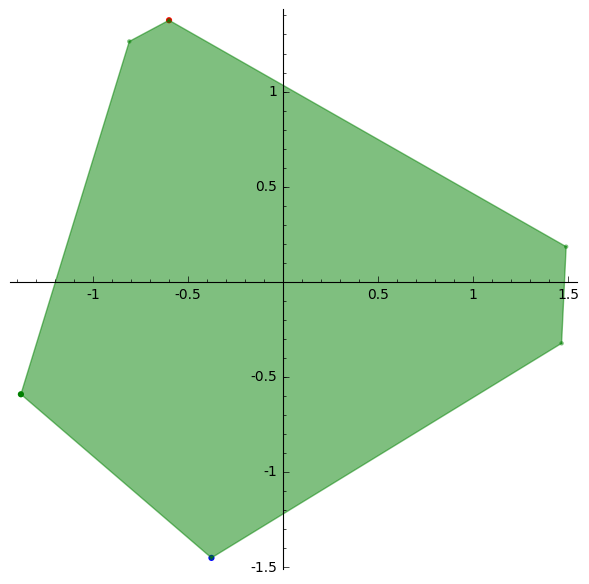

In [4]:
P.plot(alpha=0.5, color='green') + point(P.vertices_list()[0], size=20, color='red') + point(P.vertices_list()[1], size=20, color='green') + point(P.vertices_list()[2], size=20, color='blue')

We confirm that they are *not* sorted, in general (try with different random polygons).

The object `P.Vrepresentation()` is a list containing all the vertices. We can access the adjacency matrix with `P.vertex_adjacency_matrix()`. The adjacency matrix satisfies the property that: 

- an entry $(i,j)$ is 1 if and only if the vertex $i$ is adjacent to $j$;
- otherwise the entry is 0.

Let's check by looking at the first row of this matrix.

In [5]:
P.vertex_adjacency_matrix()[0]

(0, 0, 0, 1, 0, 1)

This reveals to who is connected the vertex with label 0. Below we find the corresponding indices and plot the three points, to check that they are indeed adjacent. To distinguish it, let's put a cross marker to the one that is in the middle.

In [6]:
va = P.vertex_adjacency_matrix()[0]
neighbors = [i for i in range(len(va)) if va[i] == 1]; neighbors

[3, 5]

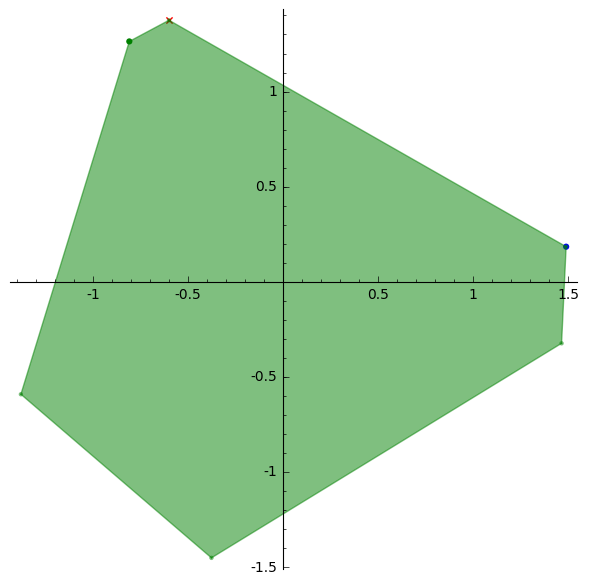

In [7]:
P.plot(alpha=0.5, color='green') + point(P.vertices_list()[0], size=20, color='red',marker='x') + point(P.vertices_list()[neighbors[0]], size=20, color='green') + point(P.vertices_list()[neighbors[1]], size=20, color='blue')

We not consider how to manipulate edges. Let's pick any constraint:

In [8]:
P.inequalities_list()[0]

[84307336781, 40775988150, 47492951323]

Recall that in the Polyhedron class, inequalities are saved in the format $(b_i,a_i)$ with $a_i^T x+b_i\geq 0$. Let's plot this line together with the polygon.

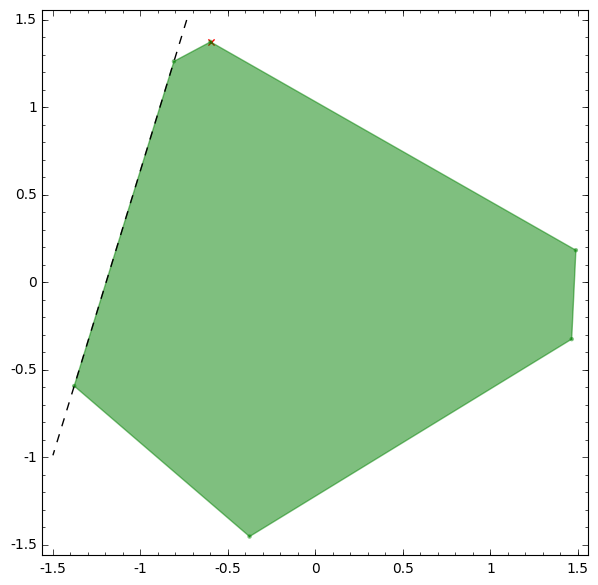

In [9]:
# pick one constraint
constraint = P.inequalities_list()[1]

# independent term and coefficient vector
bi = constraint[0]; ai = constraint[1:3]

var('x1 x2')
G = Graphics()
# initial polygon
G = G + P.plot(alpha=0.5, color='green') 

# draw one constraint
G = G + implicit_plot(lambda x1, x2 : ai[0]*x1 + ai[1]*x2+bi, (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='black')

# also draw some vertices
G = G + point(P.vertices_list()[0], size=20, color='red',marker='x')

# show
G.show()

Drawing the different constraints, one verifies that these are not sorted in any special way, as it was the case for vertices. We face this problem: **given a constraint, what are the vertices associated with it?**

Since there doesn't seem to exist any direct method (check with TAB completion), we proceed to implementing a small helper function that:

- receives a polygon,
- returns a list of pairs of integers,
- the i-th element of the list corresponds to the indices of the vertices that are associated to the i-th constraint. 

The logic is the following:

In [10]:
# pick one constraint
constraint = P.inequalities_list()[3]

# independent term and coefficient vector
bi = constraint[0]; ai = constraint[1:3]

In [11]:
vert_constraint = []
for i in range(len(P.vertices_list())):
    
    v = P.vertices_list()[i]
    val = ai[0]*v[0] + ai[1]*v[1] + bi 
    
    if val == 0:
        vert_constraint.append(i)
        print 'vertex found at position', i
    else:
        print 'vertex not found'

vertex not found
vertex not found
vertex found at position 2
vertex not found
vertex found at position 4
vertex not found


Check graphically:

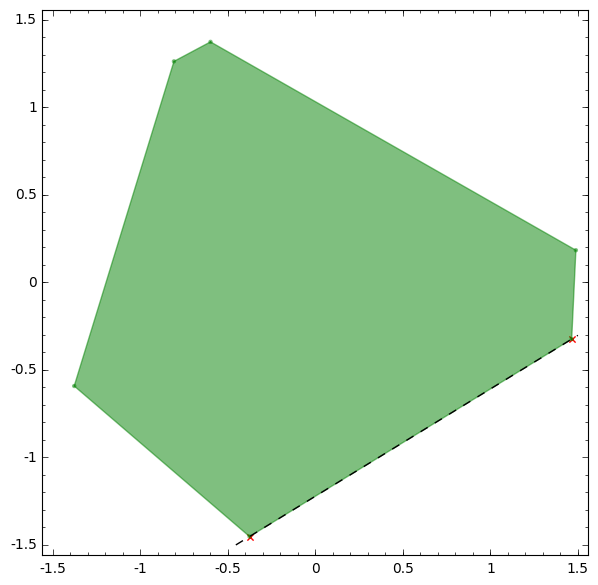

In [12]:
var('x1 x2')
G = Graphics()
# initial polygon
G = G + P.plot(alpha=0.5, color='green') 

# draw one constraint
G = G + implicit_plot(lambda x1, x2 : ai[0]*x1 + ai[1]*x2+bi, (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='black')

# also draw some vertices
G = G + point(P.vertices_list()[vert_constraint[0]], size=20, color='red',marker='x')
G = G + point(P.vertices_list()[vert_constraint[1]], size=20, color='red',marker='x')

# show
G.show()

The general function is below. Note that we make some minor improvements to make it more general, and an outer loop is added to do the computation for all edges. Some further optimizations are possible, for instance to remove vertices that have already been used twice, but this is not done.

In [13]:
def constraints_matrix(P):

    constraints_matrix = []
        
    # loop in the constraints
    for i, constraint in enumerate(P.inequalities_list()):

        # independent term and coefficient vector
        bi = constraint[0]; ai = vector([constraint[1], constraint[2]])

        constraint_i_vertices = []
    
        for j, vj in enumerate(P.vertices_list()):
            
            if (ai*vector(vj) + bi == 0):
                constraint_i_vertices.append(j)
                                
        constraints_matrix.append(constraint_i_vertices)  
                            
    return constraints_matrix                        

In [14]:
c = constraints_matrix(P); c

[[1, 2], [1, 3], [0, 3], [2, 4], [4, 5], [0, 5]]

In `polyhedron_tool`, this function is implemented as `vertex_connection`. Moreover, it accepts polygons with rational entries and with floating point entries. In the latter case, it should be used with care, since there is a comparison that involves an absolute tolerance to distinguish between vertices that may fail if these are very close (typically, smaller than 1e-6).

In [15]:
from polyhedron_tools.polygons import vertex_connections

vertex_connections(P)

[[1, 2], [1, 3], [0, 3], [2, 4], [4, 5], [0, 5]]

## Adjacent edges

The operation that we shall consider next is: **given any edge, find the intersection of its two adjacent edges.** 

This can be split into two steps:

- First, given any constraint we need to find those which are adjacent. We can use the `constraints_matrix` help function to check whether a given edge has some point in contact with another one or not (remembering to avoid the self edge, of course).
- Second, find the intersection of the adjacent edges of a given edge (outside the polygon). 

In [17]:
# pick one constraint
i = 0
constraint_i = P.inequalities_list()[i]

c = constraints_matrix(P);
neigbor_constraints = []

for j, cj in enumerate(c):
    if (c[i][0] in cj or c[i][1] in cj) and (j != i):
        neigbor_constraints.append(j)
        print j

1
3


Let's check that graphically.

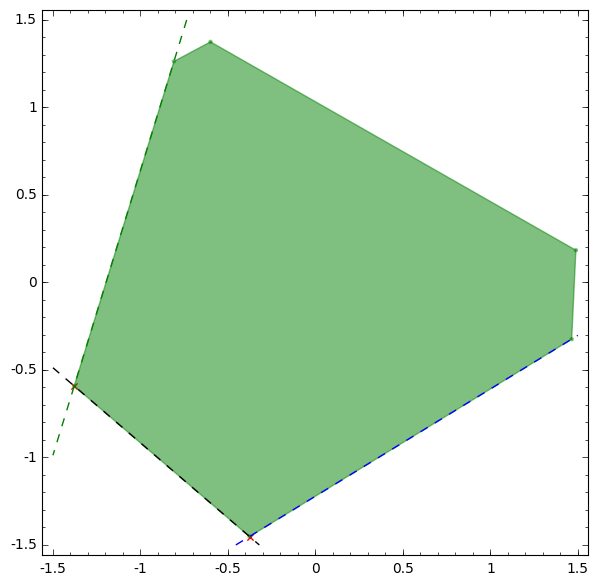

In [18]:
var('x1 x2')
G = Graphics()
# initial polygon
G = G + P.plot(alpha=0.5, color='green') 

# draw the chosen constraint (in black)
G = G + implicit_plot(lambda x1, x2 : constraint_i[1]*x1 + constraint_i[2]*x2 + constraint_i[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='black')

# draw the neigbors (in green and blue)
constraint = P.inequalities_list()[neigbor_constraints[0]]
G = G + implicit_plot(lambda x1, x2 : constraint[1]*x1 + constraint[2]*x2 + constraint[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='green')
constraint = P.inequalities_list()[neigbor_constraints[1]]
G = G + implicit_plot(lambda x1, x2 : constraint[1]*x1 + constraint[2]*x2 + constraint[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='blue')

# also draw the support vertices of the chosen (i-th) constraint
G = G + point(P.vertices_list()[c[i][0]], size=20, color='red',marker='x')
G = G + point(P.vertices_list()[c[i][1]], size=20, color='red',marker='x')

# show
G.show()

We are ready to write a general helper function. We accept that the constraint matrix has already been computed hence is passed as an argument.

In [19]:
def adjacent_neighbors(P, i, cmatrix=None):
    """ Given a polygon P, and an edge i, return the edges that are adjacent to it.
    
    "P" - a polygon (Polyhedron in 2d)
    
    "i" - integer, index of edge in P.inequalities_list()
    
    """
    
    if cmatrix is None:
        cmatrix = constraints_matrix(P)
        

    constraint = P.inequalities_list()[i]

    neighbor_constraints = []
    
    # vertices associated to the given edge i
    vert_i = cmatrix[i]
    
    for j, cj in enumerate(cmatrix):
        if (vert_i[0] in cj or vert_i[1] in cj) and (j != i):
            neighbor_constraints.append(j)
            
    return neighbor_constraints

In [20]:
adjacent_neighbors(P, 0)

[1, 3]

Now, consider the problem of finding the intersection of the adjacent neighbors of a given edge. 

In [21]:
# recall that we picked the edge i, and stored it in constraint_i

# find edges that are its neighbors 
adj_n = adjacent_neighbors(P, i)

# first one
constr_1 = P.inequalities_list()[adj_n[0]]

# second one
constr_2 = P.inequalities_list()[adj_n[1]]

# write and solve the intersection of the two lines
var('x1 x2')
eq1 = constr_1[1]*x1 + constr_1[2]*x2 == -constr_1[0]
eq2 = constr_2[1]*x1 + constr_2[2]*x2 == -constr_2[0]

p = solve([eq1, eq2], x1, x2)
p = [p[0][0].right_hand_side(), p[0][1].right_hand_side()]

Let's check graphically this result.

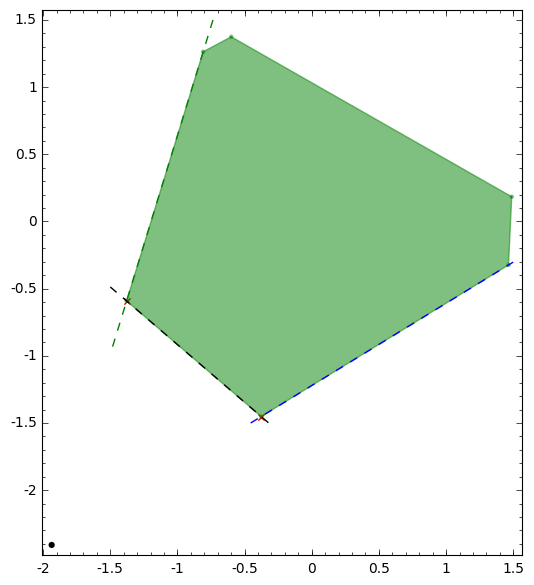

In [23]:
var('x1 x2')
G = Graphics()
# initial polygon
G = G + P.plot(alpha=0.5, color='green') 

# draw the chosen constraint
G = G + implicit_plot(lambda x1, x2 : constraint_i[1]*x1 + constraint_i[2]*x2 + constraint_i[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='black')

# draw the neigbors
constraint = P.inequalities_list()[neigbor_constraints[0]]
G = G + implicit_plot(lambda x1, x2 : constraint[1]*x1 + constraint[2]*x2 + constraint[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='green')
constraint = P.inequalities_list()[neigbor_constraints[1]]
G = G + implicit_plot(lambda x1, x2 : constraint[1]*x1 + constraint[2]*x2 + constraint[0], (x1, -scale, scale), (x2, -scale, scale),linestyle='dashed',color='blue')

# also draw the support vertices of the chosen (i-th) constraint
G = G + point(P.vertices_list()[c[i][0]], size=20, color='red',marker='x')
G = G + point(P.vertices_list()[c[i][1]], size=20, color='red',marker='x')

# finally draw the intersection point
G = G + point(p, size=20, color='black',marker='o')

# show
G.show()

We confirm that it works as expected. We put the previous two functions together.

In [25]:
def meet_neighbors(P, i, cmatrix=None):
    """ Given a polygon P, and an edge i, return the point p at which the edges that are adjacent to it intersect.
    
    "P" - a polygon (Polyhedron in 2d)
    
    "i" - integer, index of edge in P.inequalities_list()
    
    """
    
    if cmatrix is None:
        cmatrix = constraints_matrix(P)
        
    constraint_i = P.inequalities_list()[i]

    neighbor_constraints = []
    
    # vertices associated to the given edge i
    vert_i = cmatrix[i]
    
    for j, cj in enumerate(cmatrix):
        if (vert_i[0] in cj or vert_i[1] in cj) and (j != i):
            neighbor_constraints.append(j)
            
    # first one
    constr_1 = P.inequalities_list()[neighbor_constraints[0]]

    # second one
    constr_2 = P.inequalities_list()[neighbor_constraints[1]]

    # write and solve the intersection of the two lines
    var('x1 x2')
    eq1 = constr_1[1]*x1 + constr_1[2]*x2 == -constr_1[0]
    eq2 = constr_2[1]*x1 + constr_2[2]*x2 == -constr_2[0]

    p = solve([eq1, eq2], x1, x2)
    p = [p[0][0].right_hand_side(), p[0][1].right_hand_side()]            
            
    return p, neighbor_constraints

In [26]:
# small consistency check
meet_neighbors(P, 0)

([-315756298491421237617574/163067694458656545331195,
  -7460528129395831006251392/3098286194714474361292705],
 [1, 3])

To conclude, this functions (plus some small adaptations) can be used in the `polyhedron_tools` as follows:

In [27]:
from polyhedron_tools.polygons import edges_adjacent

In [28]:
edges_adjacent(P, 0)

NameError: global name 'constraints_matrix' is not defined

## Error in box shape

We start by generating a random polygon with vertices in a circle of radius `r`. The error set is a box of given radius. In Sage, the Minkowski sum of polyhedra can be performed with the plus `+` symbol. 

In [29]:
from polyhedron_tools.misc import BoxInfty
from polyhedron_tools.polygons import random_polygon_2d

# define an error bound eps in the infinity norm
eps = 0.4

# generate the box (default ring is QQ)
E = BoxInfty(center = [0.0, 0.0], radius = eps, base_ring=RDF);

# pick the number of vertices of a random polygon
nvertices = 20

# scaling factor for the vertices of P
r = 1

# generate random polygon
X = random_polygon_2d(nvertices, scale=r,base_ring=RDF)

# Minkowski addition of X and E
XE = X+E

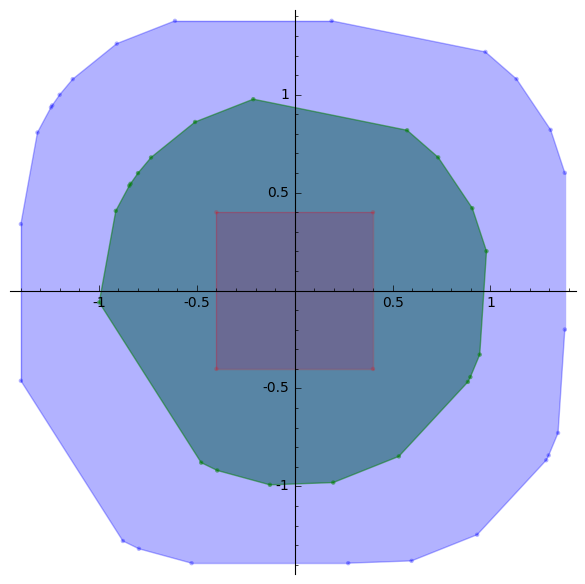

In [30]:
# plot X, E, and X+E
X.plot(alpha=0.5, color='green') + E.plot(alpha=0.2, color='red') + XE.plot(alpha=0.3, color='blue')

We address the simplification algorithm:

For all constraints in $X$:

1. Drop the constraint, creating a new vertex.
2. Check whether the new vertex lies in $X \oplus E$.
3. If not, put the constraint back.

In [31]:
from polyhedron_tools.polygons import edges_adjacent, vertex_connections, edges_intersection

Let's experiment a bit with the logic of the algorithm.

To check containment, we use the `contains` method. Note also that in the final workflow we want precisely to avoid computing the Minkowski sum; this is done in this notebook for simplicity. 

Later on we need a method to find if a point lies inside a set of the form $X \oplus E$ without actually computing all that set. 

In [33]:
# pick one constraint
i=2; constraint_i = X.inequalities_list()[i]

# compute matrix of connections
cmatrix = vertex_connections(X)

# find the point at which the neighbours of edge i intersect
p, _ = edges_intersection(X, i, cmatrix)

# check whether p lies in XE
if XE.contains(p):
    print 'p is in X+E'
else:
    print 'p is NOT in X+E'

TypeError: object of type 'int' has no len()

Let's go on assuming that $p$ is contained, remove the corresponding inequality and see the plot.

In [34]:
# original list
Xnew_ieqs = X.inequalities_list()

# pop the i-th constraint
Xnew_ieqs.pop(i)

# instantiate new polyhedron        
Xnew = Polyhedron(ieqs = Xnew_ieqs)     

print '\ninitial number of edges = ', len(X.inequalities_list())
print 'final number of edges = ', len(Xnew_ieqs)


initial number of edges =  20
final number of edges =  19


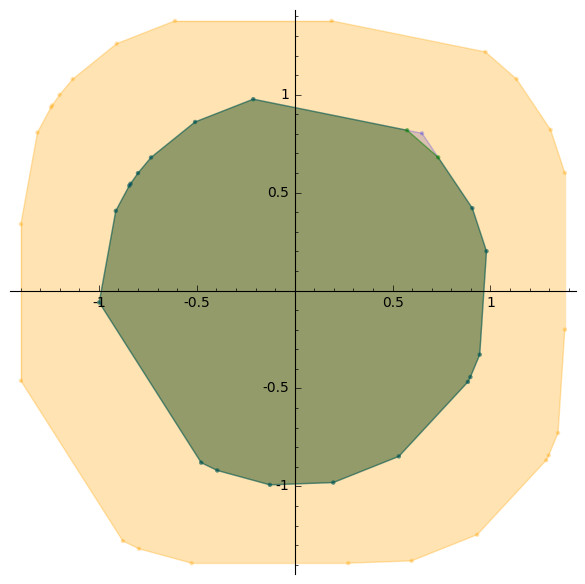

In [35]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

We see experimenting with different $i$ that it behaves as expected: when the point is contained in the Minkowski sum, then the flag is marked correctly and it corresponds to the plot.

Let's see what happens if we remove more than one constraint.

In [36]:
# == for testing purposes ==

# original list
Xnew_ieqs = X.inequalities_list()

# pop some constraints constraint
Xnew_ieqs.pop(0);
Xnew_ieqs.pop(2);

# instantiate new polyhedron        
Xnew = Polyhedron(ieqs = Xnew_ieqs)     

print '\ninitial number of edges = ', len(X.inequalities_list())
print 'final number of edges = ', len(Xnew_ieqs)


initial number of edges =  20
final number of edges =  18


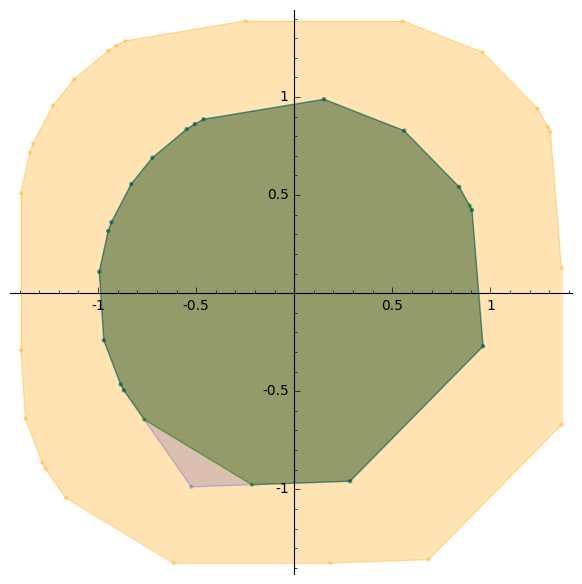

In [13]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

The problem that we may face is that two adjacent vertices sequentially doesn't make sense. We could avoid this if we only consider one out of two edges, but the problem we face is that the edges are *not sorted* a priori, as we have seen.

---

## Successive applications

As pointed above, we shall use the information that is returned by the intersection of neighbor edges to decide if there will be no conflict if we remove a certain edge.

To be on the safe side, we should not remove two edges that share the same vertex.

In [37]:
# number of original inequalities
NINEQ = len(X.inequalities_list())

# keep track of those which have been removed
edges_removed = []

# loop over constraints (step is the third argument)
for i in range(0, NINEQ, 1):
    
    # find the point at which the neighbours of edge i intersect
    p, neighbors = meet_neighbors(X, i, cmatrix)

    # check whether p lies in XE
    if XE.contains(p):
        print 'p = ', p,'    ... ', 'is in X+E'
        
        # check if there is a common vertex between edge i and any of the edges that have been removed
        got_conflict = any(cmatrix[i][0] in cmatrix[e] for e in edges_removed)
        got_conflict = got_conflict or any(cmatrix[i][1] in cmatrix[e] for e in edges_removed)
        
        if not got_conflict:
            #print 'not got conflict and i=', i
            # remove i-th inequality provided there are no conflicts
            edges_removed.append(i)
    else:
        print 'p = ', p,'    ... ', 'is NOT in X+E'
   
    print '\n'
    
# prunned list of inequalities
Xnew_ieqs = []

for i, ieq in enumerate(X.inequalities_list()):
    if i not in edges_removed:
        Xnew_ieqs.append(ieq) 

# instantiate new polyhedron        
Xnew = Polyhedron(ieqs = Xnew_ieqs)     

print '\ninitial number of edges = ', len(X.inequalities_list())
print 'final number of edges = ', len(Xnew_ieqs)

p =  [3337145953208337846004900431/3537299950743816515837302220, -310327636895822803917825052/884324987685954128959325555]     ...  is in X+E


p =  [1965600431342579841248115853/2211641986854333226076606331, -729656925741956197897320842/1579744276324523732911861665]     ...  is in X+E


p =  [5283879588634671262311856031/8124302682483910253756462653, 13051863756131053824942180591/16248605364967820507512925306]     ...  is in X+E


p =  [408056732193984798821193004/982464787479242111584611057, -7507780166887506002044308281/7719366187336902305307658305]     ...  is in X+E


p =  [-158458197422468810100594002/671310077287564798541675865, -7354001675532000887063944264/7384410850163212783958434515]     ...  is in X+E


p =  [-32021080741465898008780477855/69023743713543283407964977927, -62107985158033388981227508506/69023743713543283407964977927]     ...  is in X+E


p =  [-2122338555290493277519055205/3434287356796245004841805379, 30906970125276788357232726760/3777716092475869505325985916

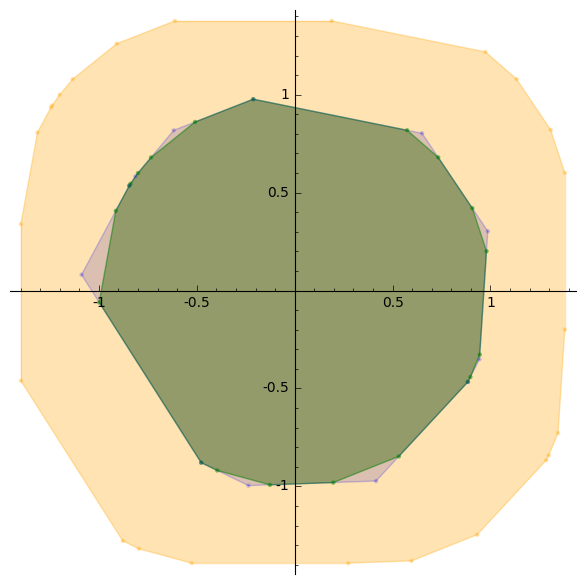

In [38]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

---

Let's put the previous code into a function.

In [39]:
def polygon_simplification(X, E):

    XE = X + E 
    
    # compute matrix of connections
    cmatrix = constraints_matrix(X)

    # number of original inequalities
    NINEQ = len(X.inequalities_list())

    # keep track of those which have been removed
    edges_removed = []

    # loop over constraints (step is the third argument)
    for i in range(0, NINEQ, 1):
    
        # find the point at which the neighbours of edge i intersect
        p, neighbors = meet_neighbors(X, i, cmatrix)

        # check whether p lies in XE
        if XE.contains(p):
           
            # check if there is a common vertex between edge i and any of the edges that have been removed
            got_conflict = any(cmatrix[i][0] in cmatrix[e] for e in edges_removed)
            got_conflict = got_conflict or any(cmatrix[i][1] in cmatrix[e] for e in edges_removed)
        
            if not got_conflict:
                # remove i-th inequality provided there are no conflicts
                edges_removed.append(i)
   
    
    # prunned list of inequalities
    Xnew_ieqs = []

    for i, ieq in enumerate(X.inequalities_list()):
        if i not in edges_removed:
            Xnew_ieqs.append(ieq) 

    # instantiate new polyhedron        
    Xnew = Polyhedron(ieqs = Xnew_ieqs)     

    print '\ninitial number of edges = ', len(X.inequalities_list())
    print 'final number of edges = ', len(Xnew_ieqs)
    
    return Xnew

In [40]:
Xnew = polygon_simplification(X, E)

IndexError: list index out of range

This function is available, together with some additional documentation, into the `polyhedron_tools.polygons` directory.

In [44]:
from polyhedron_tools.polygons import simplification_edge_prunning

simplification_edge_prunning(X, E)

NameError: global name 'var' is not defined

---

## Further tests

Let's start a fresh session and do some experiments with the simplification function.

In [45]:
from polyhedron_tools.polygons import *
from polyhedron_tools.misc import BoxInfty

# define an error bound eps in the infinity norm
eps = 0.6

# generate the box (default ring is QQ)
E = BoxInfty(center = [0.0, 0.0], radius = eps, base_ring=QQ);

# pick the number of vertices of a random polygon
nvertices = 50

# scaling factor for the vertices of P
r = 2

# generate random polygon
X = random_polygon_2d(nvertices, scale=r,base_ring=QQ)

# Minkowski addition of X and E
XE = X+E

In [47]:
%%time
Xnew = simplification_edge_prunning(X, E, XE)

NameError: global name 'var' is not defined

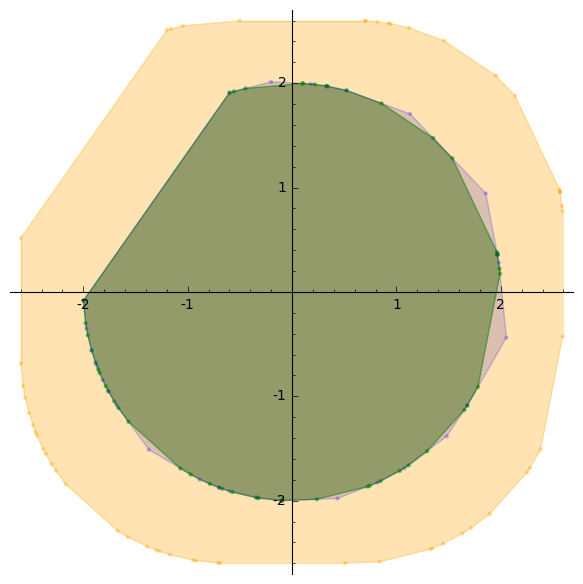

In [16]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

Let's try to apply it a second time to the new one.

In [18]:
%%time
Xnew2 = simplification_edge_prunning(Xnew, E, XE)


initial number of edges =  28
final number of edges =  17
CPU times: user 213 ms, sys: 16.5 ms, total: 230 ms
Wall time: 220 ms


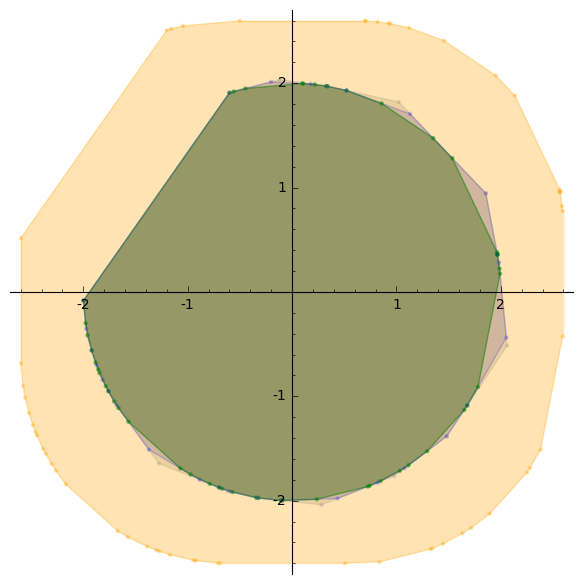

In [19]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')
G = G + Xnew2.plot(alpha=0.2, color='grey')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

If we continue applying it, does it saturate?

In [23]:
%%time
Xnew3 = simplification_edge_prunning(Xnew2, E, XE)


initial number of edges =  17
final number of edges =  9
CPU times: user 115 ms, sys: 8.21 ms, total: 123 ms
Wall time: 119 ms


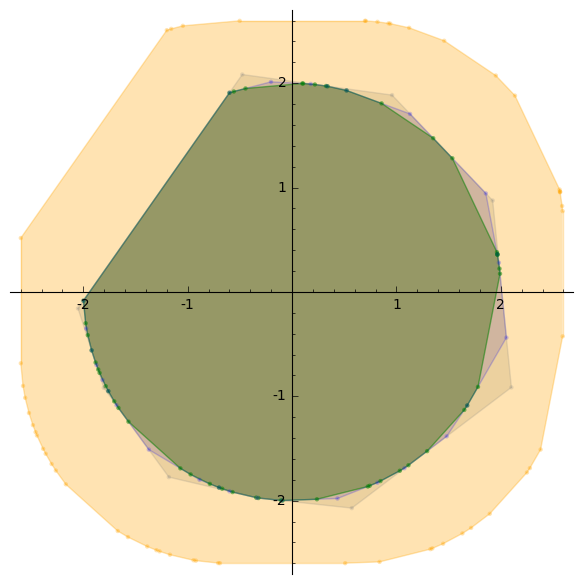

In [24]:
# plot X, E, and X+E
G = Graphics() 

# original polygon
G = X.plot(alpha=0.5, color='green') 

# reduced one
G = G + Xnew.plot(alpha=0.2, color='blue')
G = G + Xnew3.plot(alpha=0.2, color='grey')

# error box 
#G = G + E.plot(alpha=0.2, color='red')

# minkowski sum of X and E
G = G + XE.plot(alpha=0.3, color='orange')

G.show()

In [25]:
%%time
Xnew4 = polygon_simplification_edge_prunning(Xnew3, E, XE)


initial number of edges =  9
final number of edges =  6
CPU times: user 55.2 ms, sys: 4.48 ms, total: 59.7 ms
Wall time: 57.1 ms


We should be careful about several iterations. We should compare with respect to the original sum, not the one at the current step. This can be avoided by passing an optional parameter XE.

The possible choices of edges that we remove can be thought as exploring a search tree. An idea to improve further would be to decide which path ends with fewer number of vertices (e.g. using a breadth-first method).

---